## 1. Just how thirsty *is* Thursday?
<p><img style="float: left;margin:5px 20px 5px 1px;width:55%" src="https://assets.datacamp.com/production/project_489/img/shots.jpg"> </p>
<p>We have previously explored some breathalyzer test data from Ames, Iowa, USA, <a href="https://www.datacamp.com/projects/208">here</a>. Now, we focus on working with the date and time information in the data. As a college town (Go <a href="http://image.cdnllnwnl.xosnetwork.com/pics/400/NO/NOEFYIAGQIRAYLN.20090102181254.jpg">Cyclones</a>!), Ames has had its fair share of alcohol-related incidents. (For example, Google "VEISHEA riots 2014".) In this project, we examine breath alcohol test data in Ames from January 2013 to December 2017 that is published by the State of Iowa, specifically focusing on <em>when</em> these tests are administered. </p>
<p>The data file "breath<em>alcohol</em>datetimes.csv" contains 1,556 observations from breath alcohol tests collected by the Ames and Iowa State University Police Departments. The columns in this dataset are: </p>
<ol>
<li><strong>DateTime</strong> - date &amp; time of test (datetime, "America/Chicago")              </li>
<li><strong>Location</strong> - who administered the test, Ames PD or ISU PD? (char.)</li>
<li><strong>Gender</strong> - gender (M,F) of person being tested (char.)</li>
<li><strong>Res1</strong> - first breath alcohol reading (num.)</li>
<li><strong>Res2</strong> - second breath alcohol reading (num.)</li>
</ol>
<p>First, we create a bar chart showing number of tests by day of the week to see when the most tests were done.   </p>

Parsed with column specification:
cols(
  DateTime = col_datetime(format = ""),
  Location = col_character(),
  Gender = col_character(),
  Res1 = col_double(),
  Res2 = col_double()
)


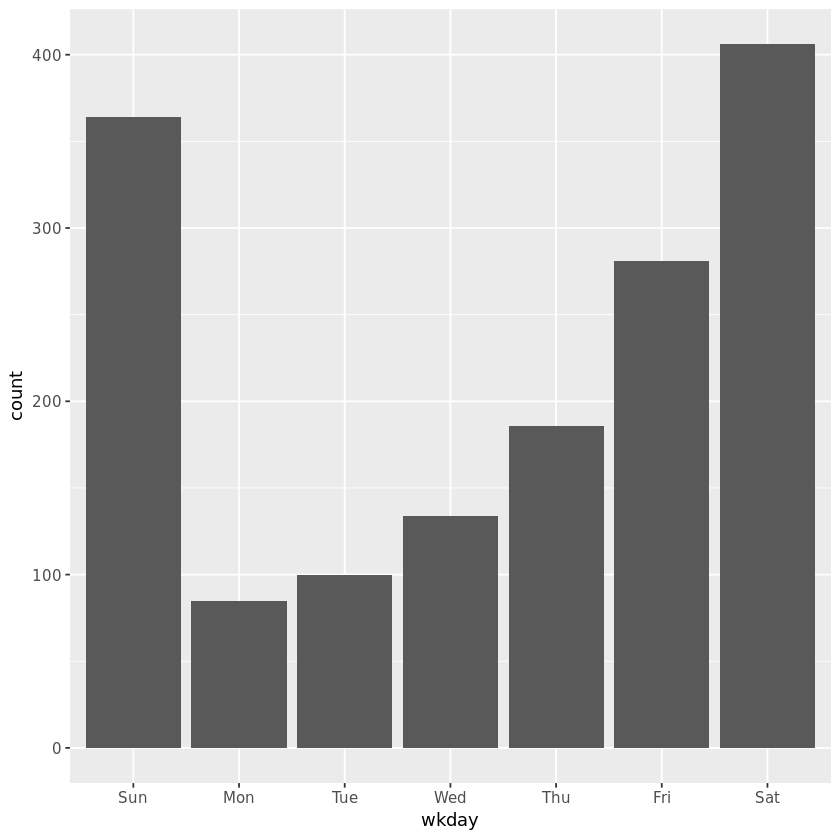

In [96]:
# load necessary packages 
library(tidyverse)
library(lubridate)

# read in the data from breath_alcohol_datetimes.csv
ba_dates <- read_csv("datasets/breath_alcohol_datetimes.csv")

# change DateTime column to America/Chicago with force_tz
ba_dates <- ba_dates %>% mutate(DateTime = force_tz(DateTime, "America/Chicago"))

# create a wkday column in the ba_dates 
ba_dates <- ba_dates %>% mutate(wkday = wday(DateTime, label=TRUE))

# create a bar chart of # tests by day of week
ggplot(data = ba_dates, aes(x = wkday)) + 
  geom_bar()

## 2. What makes Sunday so fun-day?
<p>Well, that wasn't terribly surprising: Friday and Saturday are two of the most common days of the week for breathalyzer tests in a college town. But what might be <em>somewhat</em> surprising is that more tests occur on Sunday than on Friday.  But <em>when</em> on Sunday are these tests being administered?  To investigate, we look at the hour of the test and compare this data for Friday, Saturday, and Sunday. </p>

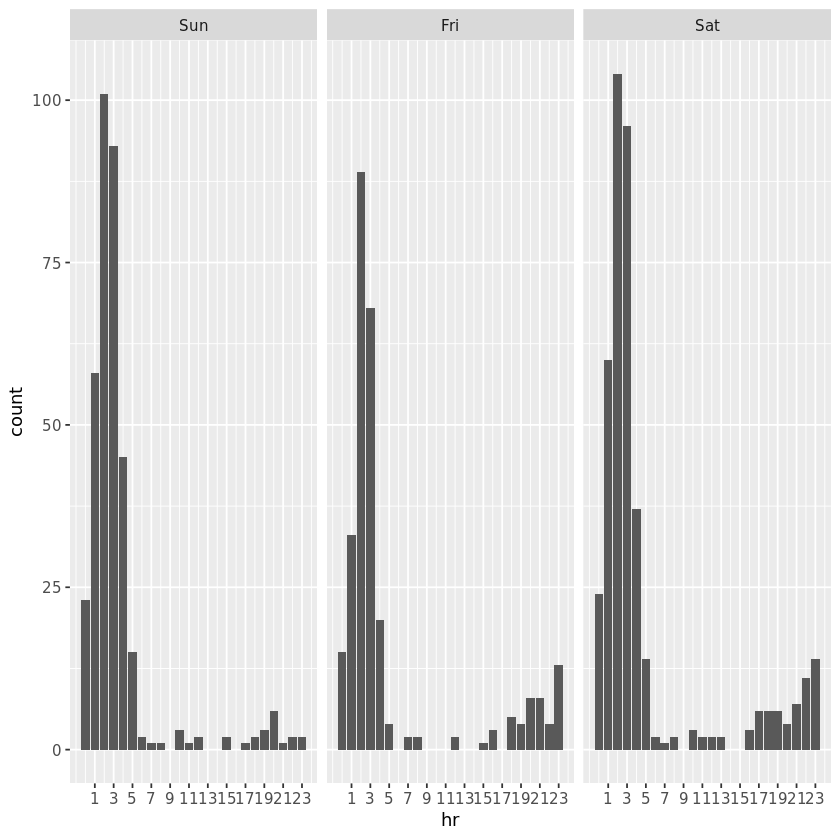

In [98]:
# create hour variable
ba_dates <- ba_dates %>% mutate(hr = hour(DateTime))

# create weekend data frame
weekend <- ba_dates %>% filter(wkday %in% c('Fri', 'Sat', 'Sun'))

# plot side-by side bar charts counting hour of the day of tests for each weekend day
ggplot(data = weekend) + 
  geom_bar(aes(x = hr)) + 
  facet_grid(.~wkday) + 
  scale_x_continuous(breaks = 1:12*2-1) # for ease of readability 

## 3. Trends in testing over time
<p>We learned that most of the tests administered on Sundays are during early morning, from midnight to 5am. Strangely, the same pattern also exists on Friday mornings. (This is likely because Thursdays are "Mug Nights" in Ames, where you can get discounted drinks if you bring in the designated reusable mug.) Returning to the full dataset, we now explore  the pattern of alcohol tests over the years. To look at the "bigger picture," let's count up the number of tests per day, and visualize the resulting time series using a line plot.</p>

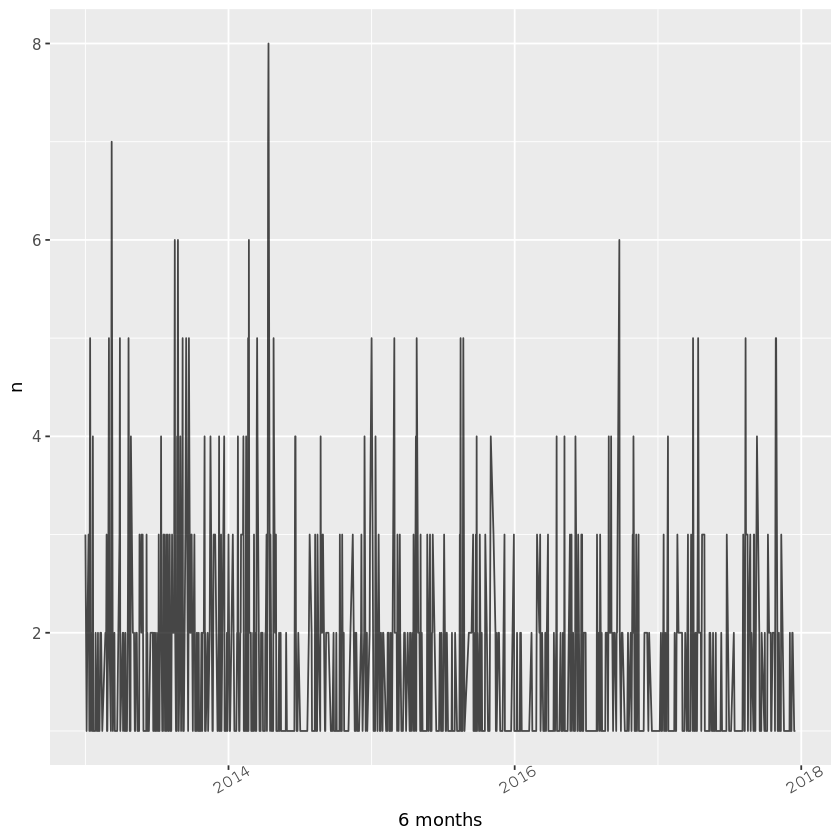

In [100]:
# create a date column rounded to the nearest day. as.Date() is for the plot later
ba_dates <- ba_dates %>% mutate(date = as.Date(round_date(DateTime, unit='day'))) 

# count number of tests per date 
ba_summary <- ba_dates %>% count(date)

# pipe the result from above into ggplot() using geom_line to create a time series plot.
ba_summary %>% 
  ggplot() + 
  geom_line(aes(x = date, y = n), alpha = .7) + # change alpha for readability 
  scale_x_date("6 months") + 
  theme(axis.text.x = element_text(angle = 30)) # make x-axis more readable 

## 4. College football
<p>In the time series, we see many days that have zero breathalyzer tests administered. In the entire five year period, there were at most eight tests in a day. There are many days with three or more tests in a day, and we wonder if the Iowa State football schedule may match up with some of those high test days. We next explore the Iowa State football schedule for 2013-2017. Data were downloaded from <a href="https://www.sports-reference.com/cfb/">sports-reference.com</a>.</p>
<p><img style="float: left;margin:5px 20px 5px 1px;width:95%" src="https://assets.datacamp.com/production/project_489/img/football.jpg"> </p>

In [102]:
# read in the football data 
isu_fb <- read_csv("datasets/isu_football.csv")

# make Date a date variable 
isu_fb <- isu_fb %>% mutate(Date = parse_date(Date, format = "%b %d, %Y"))

# filter ba_summary
ba_fb <- ba_summary %>%
    filter(date %in% isu_fb$Date)

# arrange ba_fb by number of tests from high to low and print first six rows 
ba_fb %>% arrange(desc(n)) %>% head(6)

Parsed with column specification:
cols(
  G = col_integer(),
  Date = col_character(),
  Time = col_time(format = ""),
  Day = col_character(),
  School = col_character(),
  Home = col_character(),
  Opponent = col_character(),
  Conf = col_character(),
  Res = col_character(),
  Pts = col_integer(),
  Opp = col_integer(),
  W = col_integer(),
  L = col_integer(),
  Streak = col_character(),
  Notes = col_character(),
  TV = col_character()
)


date,n
2016-09-24,6
2017-10-28,5
2013-08-31,4
2013-09-14,4
2013-11-16,4
2016-09-03,4


## 5. Home vs. away? Win vs. lose?
<p>The most breathalyzer tests given on a football game day was on Sept. 24, 2016. This was a home game against San Jose State that Iowa State won 44-10. The win/loss information is in the <code>Res</code> column in <code>isu_fb</code>. Could the home game win have led to some excessive celebrations that resulted in more breathalyzer tests than an away win or a home loss? </p>

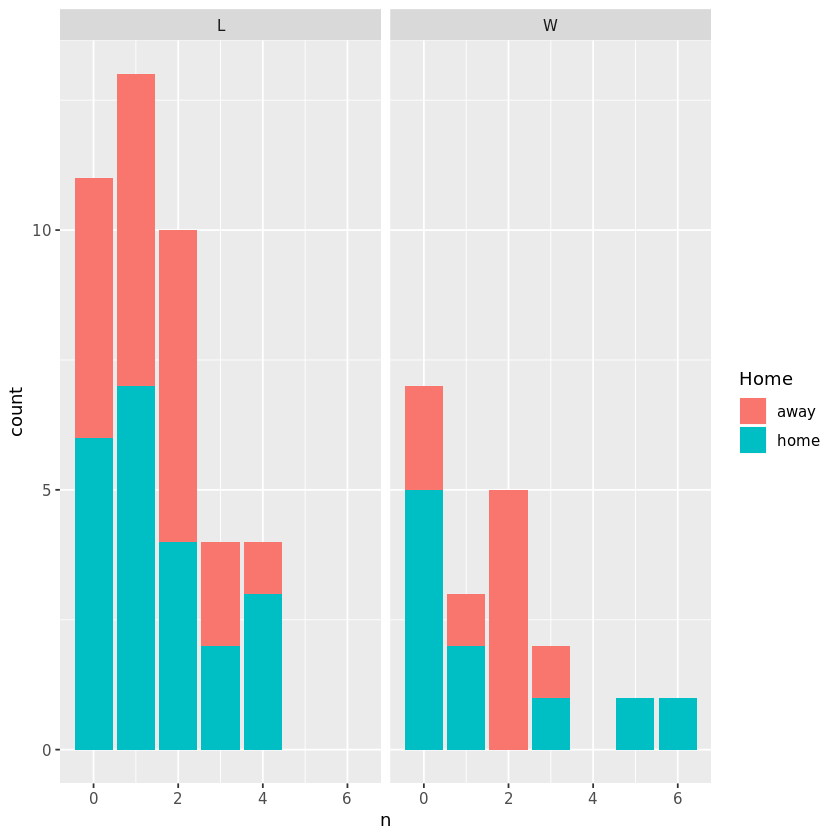

In [104]:
# join ba_summary to isu_fb 
isu_fb2 <- isu_fb %>% left_join(ba_summary, by = c('Date' = 'date'))

# change nas to 0s 
isu_fb2 <- isu_fb2 %>% mutate(n = ifelse(is.na(n), 0, n))

# plot 
ggplot(isu_fb2, aes(n, fill=Home)) +
    geom_bar() + 
    facet_grid(.~Res)

## 6. Monthly counts
<p>The football season typically lasts from September through November. As we just saw, Iowa State football has more losses than wins in the last few years. The men's basketball team, however, has traditionally been very successful. The basketball season usually lasts from November through March. We now investigate the number of breathalyzer tests by month to see if the basketball months have more tests than the football months. </p>

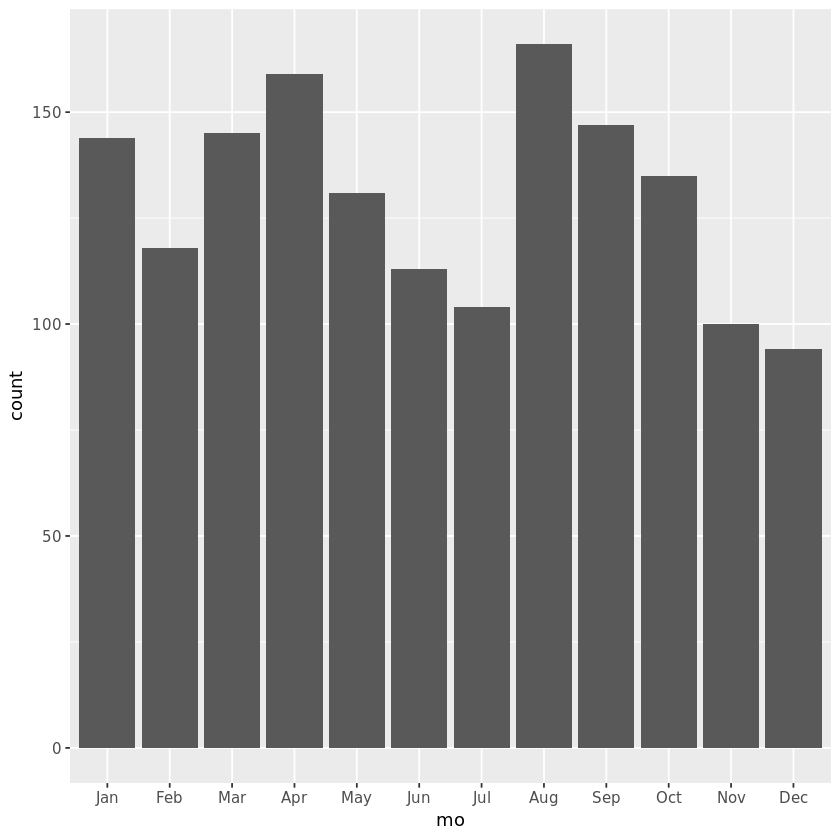

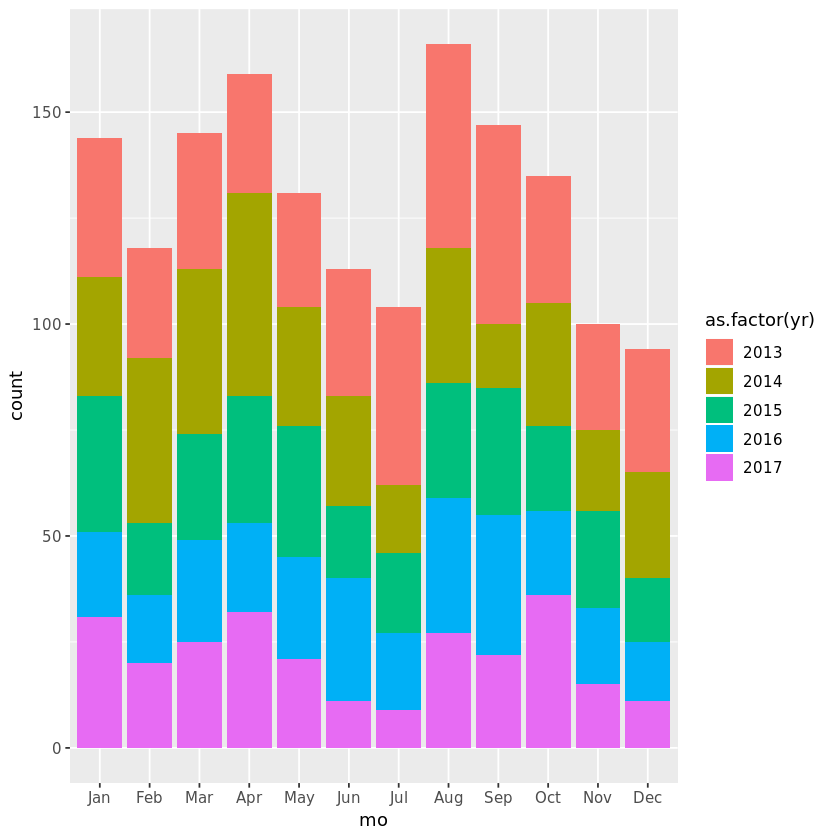

In [106]:
# create a mo and a yr column in ba_dates
ba_dates <- ba_dates %>% mutate(mo = month(date, label=TRUE), yr = year(date))

# make bar chart by mo.
ggplot(ba_dates, aes(mo)) +
    geom_bar()

# color by year 
ggplot(ba_dates, aes(mo, fill=as.factor(yr))) +
    geom_bar()

## 7. VEISHEA: an old tradition
<p>The monthly bar charts show that the months with the most test per day are August and April. April is a surprise because there are no major college sports in April, and students are busy studying for finals and finishing semester projects. Well, at Iowa State, there was a historical weeklong festival known as VEISHEA held in April every year.  It was cancelled in 2014 due to the many drinking-related arrests, violence, and vandalism that occurred yearly. Looking at the VEISHEA weeks and subsequent non-VEISHEA weeks, can we see the effect of the cancellation in the breathalyzer data? </p>

In [108]:
# In 2013, VEISHEA was held from April 15-21. In 2014, it was held from April 7-13. 
v13 <- interval(make_date(2013, 4, 15) , make_date(2013, 4, 21), tzone = "America/Chicago")
v14 <- interval(make_date(2014, 4, 07) , make_date(2014, 4, 13), tzone = "America/Chicago")
# Other comparable VEISHEA weeks in 2015-2017
v15 <- interval(make_date(2015, 4, 13) , make_date(2015, 4, 19), tzone = "America/Chicago")
v16 <- interval(make_date(2016, 4, 11) , make_date(2016, 4, 17), tzone = "America/Chicago")
v17 <- interval(make_date(2017, 4, 10) , make_date(2017, 4, 16), tzone = "America/Chicago")

# filter ba_dates for only the 5 veishea intervals
veishea <- ba_dates %>% filter(date %within% list(v13, v14, v15, v16, v17) | FALSE)

# count up years 
veishea %>% count(year(date))

year(date),n
2013,12
2014,24
2015,8
2016,8
2017,11


## 8. Looking at BAC
<p>Finally, let's look at the actual results of the breathalyzer tests. Based on our knowledge from Section 2, we suspect that the highest BAC results occur late and night and in the early morning, since those times are most common for tests on the weekends. </p>

ERROR while rich displaying an object: Error in FUN(X[[i]], ...): object '....' not found

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     rpr <- mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     rpr <- mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. mime2repr[[mime]](obj)
8. repr_text.default(obj)
9. paste(capture.output(print(obj)), collapse = "\n")
10. capture.output(print(obj))
11. evalVis(expr)
12. withVisible(eval(expr, pf))
13. eval(expr, pf)
14. eval(expr, pf)
15. print(obj)
16. print.ggplot(obj)
17. ggplot_build(x)
18. ggplot_build.ggplot(x)
19. by_laye

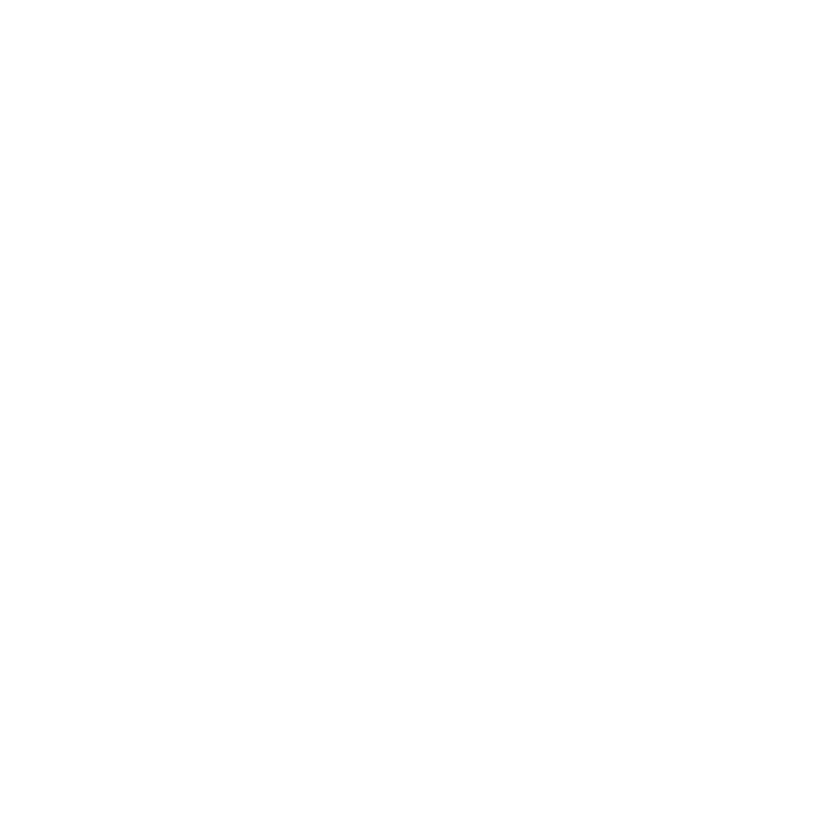

In [110]:
# take a mean of res1, res2
ba_dates <- ba_dates %>%
    mutate(res = mean(Res1, Res2))

# library the ggridges package
library(ggridges)

# make ridgeline plot 
ggplot(data = ba_dates, aes(x = res, y = ...., group = ....)) +
  # some style choices made already
  geom_density_ridges(alpha = 0.7, fill = "steelblue", bandwidth = .01, rel_min_height = 0.0001) + 
  scale_y_continuous(breaks = 0:23)

## 9. A more honest plot
<p>In the previous ridgeline plot, there are values below zero. This is impossible given the context: you cannot have negative alcohol concentration in your blood. We examine the zeroes below and make a more honest ridgeline plot. </p>

In [112]:
# create a zero indicator variable 
ba_dates <- ba_dates %>% mutate(zero = .... == ....)

# tabulate the data by the zero column
# .... YOUR CODE FOR TASK 8 ....

# redo ridge with no 0s
ba_dates %>% filter(....) %>% 
ggplot(aes(x = ...., y = ...., group = ....)) +
  geom_density_ridges(alpha = 0.7, fill = "steelblue", bandwidth = .01, rel_min_height = 0.005) + 
  scale_y_continuous(breaks = 0:23)

ERROR: Error in mutate_impl(.data, dots): Evaluation error: object '....' not found.


## 10. The dangers of binge drinking
<p>At a breath alcohol level of 0.16-0.30, a person will experience significant "speech, memory, coordination, attention, reaction time, [and] balance" impairment. Someone's "driving-related skills" and "judgement and decision making" are dangerously impaired, and they may experience "blackouts, vomiting [...] and loss of consciousness". BAC of 0.31 or above is life-threatening with "significant risk of death" (<a href="https://medlineplus.gov/magazine/issues/spring14/articles/spring14pg23.html">source</a>). We conclude by looking at the time of day during which the most dangerous levels of alcohol consumption appear in the Ames data. Do the dates, times, and days of week match what one would expect? </p>
<p>While this report has taken a fun and playful tone, it is important to be aware of the seriousness of this issue. According to <a href="https://www.niaaa.nih.gov/alcohol-health/overview-alcohol-consumption/alcohol-facts-and-statistics">research</a>, nearly 2,000 college students die each year from alcohol-related injuries. If you or a loved one are struggling with alcohol abuse, please seek <a href="https://pubs.niaaa.nih.gov/publications/treatment/treatment.htm">help</a>. </p>

In [ ]:
# filter the ba_dates data to contain only those with the most dangerous result
danger <- ba_dates %>% ....

# print danger
print(danger)